# To-do list

- [ ] 查看不同 sample 下的 share，no-share 的比例
- [ ] check DddA_wt_6 only的信号为 0 的点是否真是0
- [ ] 看 650 个 old share 中除了 约 400 个 call 到的点之外，剩下 250 个左右是否无信号，或者是有信号没过 cutoff
- [ ] 直接进行align所有的点，根据 share 与否，align 信息进行分类确定 share 或者不 share，再去看 tale align，确定 IND、DEP
- [ ] JAK2, SIRT6 only share call motif

# packages and settings 

import python packages

In [239]:
import collections
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycircos
# from matplotlib_venn import venn2
from pybedtools import BedTool
from pycircos import Garc, Gcircle
from upsetplotly import UpSetPlotly

enable rpy2

In [2]:
# enables the gaR magic,  not neceasary  if you’ve already done this
%load_ext rpy2.ipython
# %reload_ext rpy2.ipython

import R libraries

In [338]:
%%R
# 可以再%%R后面放光标 cmd + i
library(tidyverse)
library(ggpubr)
library(ggrepel)
library(ggupset)
library(UpSetR)

# 初步探索poisson table
- log2_FC: log2(treat_count.norm/ctrl_count.norm), 如果ctrl_count.norm不存在，就用 chr 突变背景
- log2_FC_mut: log2(treat_mut_count.norm/ctrl_mut_count.norm), 如果ctrl_mut_count.norm不存在，就用 chr 突变背景
- region_block_state: B-Blocked, S-SNV, N-Non-SNV

In [ ]:
file = '../poisson_res/poisson_res_all.tsv.gz'

In [ ]:
df = pd.read_csv(file, header=0, index_col=None, sep='\t')
df.head()

In [ ]:
# df.info()

In [ ]:
# df.isna().sum()

In [ ]:
# # 查看一下两列 NA 是什么
# test_df = df.query('region_highest_site_index.isna()')
# test2_df = df.query('log2_FC_mut.isna()')

In [ ]:
df = df.assign(bed_name=df.mpmat_index + '_highest_'
               + df.region_highest_site_index,
               strand='.')
df = df[df['<sample>'] != 'test']
df

# find significant region

## strict selection 

In [ ]:
df_sign_strict = (
    df.query('FDR <= 0.0001').query('log2_FC_mut >= 2').query(
        'ctrl_mut_count <= 1').query('`treat_mut_count.norm` * 100 >= 10').
    query('treat_mut_count >= 20').query(
        'treat_mut_count / treat_count >= 0.15').query(
            'region_block_site_num <= 1').query(
                'region_highest_site_mut_ratio >= 0.35')  # 1892
)

print(df_sign_strict.shape[0])
df_sign_strict.groupby('<sample>').describe()

In [ ]:
df_sign_strict.isna().sum().sum()

## lenient selection

In [ ]:
# nature protocol standard
# df_sign_lenient = (df
#                    .query('FDR <= 0.01')
#                    .query('log2_FC_mut >= 2')
#                    .query('ctrl_mut_count <= 1')
#                    .query('`treat_mut_count.norm` * 100 >= 5')
#                    .query('treat_mut_count >= 10')
#                    .query('treat_mut_count / treat_count >= 0.15')
#                    .query('region_block_site_num <= 1')
#                    .query('region_highest_site_mut_ratio >= 0.30')  # 4007
#                    )

# print(df_sign_lenient.shape[0])
# df_sign_lenient.groupby('<sample>').describe()

# 2022-10-27 update
df_sign_lenient = (df
                   .query('FDR <= 0.01').query('log2_FC_mut >= 2')
                   .query('ctrl_mut_count <= 1')
                   .query('`treat_mut_count.norm` * 100 >= 5')
                   .query('treat_mut_count >= 10')
                   .query('treat_mut_count / treat_count >= 0.15')
                   .query('region_block_site_num <= 1')
                   .query('region_highest_site_mut_ratio >= 0.30')  # 4007
                   )

print(df_sign_lenient.shape[0])
df_sign_lenient.groupby('<sample>').describe()

In [ ]:
df_sign_lenient.isna().sum().sum()

In [ ]:
df = df_sign_lenient
print(df.shape)
df.head()

## fix mpmat_index (add old into it) -> df_pois

In [ ]:
df_old_id = pd.read_csv(
    "../tables/20220312-DdCBE-off_target_type.FinallistV4.CheckPrimer.AddV4ID.tsv",
    sep='\t', header=0, usecols=['region_id'],)
df_old_id.region_id.describe()

In [ ]:
df_old_id[['chrom', 'start', 'end'
           ]] = pd.Series(df_old_id.region_id.unique()).str.split('_',
                                                                  expand=True)
df_old_id = df_old_id.iloc[:, 1:4]
df_old_id['start'] = df_old_id['start'].astype(int)
df_old_id['end'] = df_old_id['end'].astype(int)
df_old_id

In [ ]:
df_old_id.info()

In [ ]:
df_new_id = pd.Series(df.mpmat_index.unique()).str.split('_', expand=True)
df_new_id.columns = ['chrom', 'start', 'end']
df_new_id['start'] = df_new_id['start'].astype(int)
df_new_id['end'] = df_new_id['end'].astype(int)

df_new_id

In [ ]:
bed_new = BedTool.from_dataframe(df_new_id)
bed_nat = BedTool.from_dataframe(df_old_id)

> https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html

![](https://tva1.sinaimg.cn/large/008vxvgGly1h7jy4v629sj30ld0j9wg7.jpg)

In [ ]:
df_bed_to_fix = bed_new.intersect(bed_nat, loj=True).to_dataframe()
df_bed_to_fix.columns = ['chrom', 'start', 'end', 'chrom2', 'start2', 'end2']

df_bed_to_fix

In [ ]:
# end2 为-1 代表老点不存在，
# end2 有值说明，新老点重合，以老点 region 坐标为准进行替换
# df_test = df_bed_to_fix.query('end2 != -1')
# abs((df_test.end2 - df_test.start2 - df_test.end + df_test.start)).describe()

# 唯一标识mpmat_index

df_bed_to_fix['mpmat_index'] = df_bed_to_fix['chrom'] + '_' + \
    df_bed_to_fix['start'].astype(str) + '_' + df_bed_to_fix['end'].astype(str)

df_bed_to_fix_part1 = df_bed_to_fix.query('end2 == -1')[[
    'mpmat_index', 'chrom', 'start', 'end'
]].copy()
df_bed_to_fix_part2 = df_bed_to_fix.query('end2 != -1')[[
    'mpmat_index', 'chrom2', 'start2', 'end2'
]].copy()

df_bed_to_fix_part1.columns = [
    'mpmat_index', 'chr_name', 'region_start', 'region_end'
]
df_bed_to_fix_part2.columns = [
    'mpmat_index', 'chr_name', 'region_start', 'region_end'
]

df_bed_fixed_coordinate = pd.concat([df_bed_to_fix_part1, df_bed_to_fix_part2],
                                    axis=0)
df_bed_fixed_coordinate

In [ ]:
# 发现两个 duplicated 的 mpmat_index，check 一下为什么
# print(df_bed_fixed_coordinate[df_bed_fixed_coordinate.mpmat_index.duplicated()])

print(df_bed_fixed_coordinate.query('mpmat_index=="chr10_22989043_22989070"'))
print(df_bed_fixed_coordinate.query('mpmat_index=="chr17_67963461_67963466"'))
#                  mpmat_index chr_name  region_start  region_end
# 864  chr10_22989043_22989070    chr10      22989049    22989070
# 865  chr10_22989043_22989070    chr10      22989052    22989071
#                   mpmat_index chr_name  region_start  region_end
# 2931  chr17_67963461_67963466    chr17      67963444    67963466
# 2932  chr17_67963461_67963466    chr17      67963458    67963466

# 发现其实就是没定下来最终的导致了有多出来的点，图方便取第一个，注意以后 debug！
# DEBUG

df_bed_fixed_coordinate.drop_duplicates(subset='mpmat_index',
                                        keep='first',
                                        inplace=True)

df_bed_fixed_coordinate

In [ ]:
df_bed_fixed_coordinate2 = (
    df_bed_fixed_coordinate
    .merge(df, on=['mpmat_index'], how='left')
    .drop(
        columns=['chr_name_y', 'region_start_y', 'region_end_y']
    )
    .rename(
        columns={
            'chr_name_x': 'chr_name',
            'region_start_x': 'region_start',
            'region_end_x': 'region_end'}
    )
)

sample_names = df_bed_fixed_coordinate2.pop('<sample>')
mpmat_indexes = df_bed_fixed_coordinate2.pop('mpmat_index')
# 利用insert方法插入取出的数据列到指定位置

df_bed_fixed_coordinate2.insert(0, '<sample>', sample_names)
df_bed_fixed_coordinate2.insert(4, 'mpmat_index', mpmat_indexes)

# fix mpmat_index
df_bed_fixed_coordinate2['mpmat_index'] = df_bed_fixed_coordinate2['chr_name'] + '_' + \
    df_bed_fixed_coordinate2['region_start'].astype(str) + '_' + df_bed_fixed_coordinate2['region_end'].astype(str)

df_bed_fixed_coordinate2

In [ ]:
# sample 内部无重合
for _, _df in df_bed_fixed_coordinate2.groupby('<sample>'):
    print(_df.duplicated().sum())

In [ ]:
df_pois = df_bed_fixed_coordinate2.copy()
df_pois.head()

# 现在只要是有 nature 当中的 region，都和 nature 的 coordinate
# 和mpmat_index保持一致了，后面如果回溯命名，直接和 v4 的 table merge一下即可

In [ ]:
df_pois.isna().sum().sum()

In [ ]:
# df_pois.to_csv('./_temp/2022-10-28_for_home_use.csv', index=None)

# reload data

In [5]:
df_pois = pd.read_csv('./_temp/2022-10-28_for_home_use.csv', header=0, index_col=None)
df_pois

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR,bed_name,strand
0,DetectSeq_ATP8-DddA11_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.000000,2.801598,"0,1,2,3 22,0,0,0 689,406,500,0",7.415426,8.434072,TestOK,9.573874e-183,1.536847e-177,chr1_631391_631393_highest_chr1_631392_CT,.
1,DetectSeq_ATP8-DddA6_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.000000,2.750688,"0,1,2,3 22,0,0,0 511,169,485,0",7.070792,8.407614,TestOK,2.632264e-166,4.829081e-161,chr1_631391_631393_highest_chr1_631392_CT,.
2,DetectSeq_ATP8-DddAwt_REP-1,chr1,631391,631393,chr1_631391_631393,3,1,2,"chr1_631391_CT,chr1_631392_CT,chr1_631393_CT",B-N-N,...,0.000000,0.181582,"0,1,2,3 22,0,0,0 157,60,43,0",4.442013,4.486517,TestOK,4.391279e-12,2.014030e-07,chr1_631391_631393_highest_chr1_631392_CT,.
3,DetectSeq_ATP8-DddA11_REP-1,chr1,631778,631791,chr1_631778_631791,3,0,3,"chr1_631778_CT,chr1_631787_CT,chr1_631791_CT",N-N-N,...,0.000000,3.260583,"0,1,2,3 40,0,0,0 534,278,413,258",6.447891,8.652952,TestOK,2.915445e-214,5.348597e-209,chr1_631778_631791_highest_chr1_631791_CT,.
4,DetectSeq_ATP8-DddA6_REP-1,chr1,631778,631791,chr1_631778_631791,3,0,3,"chr1_631778_CT,chr1_631787_CT,chr1_631791_CT",N-N-N,...,0.000000,3.001335,"0,1,2,3 40,0,0,0 530,320,528,69",6.521031,8.533426,TestOK,3.072057e-182,6.575230e-177,chr1_631778_631791_highest_chr1_631787_CT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002,DetectSeq_SIRT6-DddA11_REP-1,chrX,41024523,41024536,chrX_41024523_41024536,13,0,13,"chrX_41024494_GA,chrX_41024498_GA,chrX_4102450...",N-N-N-N-N-N-N-N-N-N-N-N-N,...,0.000000,0.311431,"0,1,2,3,4,5,6,7,8,9,10,11,12,13 22,0,0,0,0,0,0...",3.245836,5.533199,TestOK,3.108715e-19,8.180768e-16,chrX_41024494_41024536_highest_chrX_41024528_GA,.
4003,DetectSeq_SIRT6-DddA11_REP-1,chrX,72126743,72126762,chrX_72126743_72126762,9,0,9,"chrX_72126743_CT,chrX_72126744_CT,chrX_7212674...",N-N-N-N-N-N-N-N-N,...,0.000000,0.088980,"0,1,2,3,4,5,6,7,8,9 28,0,0,0,0,0,0,0,0,0 9,0,3...",0.971913,3.725844,TestOK,3.269560e-05,7.913254e-03,chrX_72126743_72126762_highest_chrX_72126750_CT,.
4004,DetectSeq_SIRT6-DddA11_REP-1,chrX,103211203,103211249,chrX_103211203_103211249,8,0,8,"chrX_103211187_GA,chrX_103211197_GA,chrX_10321...",N-N-N-N-N-N-N-N,...,0.000000,0.172399,"0,1,2,3,4,5,6,7,8 34,0,0,0,0,0,0,0,0 27,10,12,...",2.135412,4.680040,TestOK,2.985607e-10,2.539152e-07,chrX_103211187_103211215_highest_chrX_10321121...,.
4005,DetectSeq_SIRT6-DddA11_REP-1,chrX,132292961,132292983,chrX_132292961_132292983,10,0,10,"chrX_132292956_GA,chrX_132292961_GA,chrX_13229...",N-N-N-N-N-N-N-N-N-N,...,0.002532,0.088980,"0,1,2,3,4,5,6,7,8,9,10 40,0,1,0,0,0,0,0,0,0,0 ...",1.135412,5.135412,TestOK,3.269560e-05,7.913254e-03,chrX_132292956_132292983_highest_chrX_13229298...,.


# [TODO] share analysis of different DdCBE treatment -> upset plot

In [ ]:
# # 找到每个样本中 call 到 region 的mpmat_index
# dt_mpmat_index = {}

# for sample, _df in df_sign_lenient.groupby('<sample>'):
#     dt_mpmat_index[sample] = _df.mpmat_index.tolist()

# # dt_mpmat_index
# dt_mpmat_index['DetectSeq_ATP8-DddA11_REP-1'][:10]

In [ ]:
# # TODO
# def check_mpmat_index_in_others(x):
#     dt_mpmat_index_isin = dict()

#     for sample, sample_mpmat_index in dt_mpmat_index.items():
#         if x['mpmat_index'] in sample_mpmat_index:
#             pass

# analysis with old TAS-independent list (650 sites) -> df_aim_mpmat

## generate old TAS-independent off-target mpmat to call regions

In [ ]:
# df_old_final_list = pd.read_csv(
#     "../tables/20220312-DdCBE-off_target_type.FinallistV4.CheckPrimer.AddV4ID.tsv",
#     sep='\t',
#     header=0,
#     usecols=['region_id', 'off_target_id.V4.ND4', 'off_target_id.V4.ND5.1', 'off_target_id.V4.ND6'],
# )
# df_old_final_list.columns = ['mpmat_index', 'id_ND4', 'id_ND5.1', 'id_ND6']
# df_old_final_list.head()

In [ ]:
# def query_ind(x):
#     x = x.fillna('')
#     if 'IND' in x['id_ND4']: return True
#     elif 'IND' in x['id_ND5.1']: return True
#     elif 'IND' in x['id_ND6']: return True
#     else: return False

# df_old_final_list.apply(query_ind, axis=1).sum()

In [ ]:
# df_old_share = df_old_final_list[df_old_final_list.apply(query_ind, axis=1)].reset_index(drop=True)
# df_old_share

In [ ]:
# # 拿 650 个 old share 的点做一个 mpmat 出来去对着这五个 sample call 一下相关位置
# df_mpmat = pd.read_csv(
#     '../tables/293T-DdCBE-merge_hg38.MAPQ20.C6_M4_R1_T10.sort.V4.mpmat.gz',
#     sep='\t',
#     header=None,
# )
# df_mpmat['mpmat_index'] = df_mpmat[0] + '_' + df_mpmat[1].astype(str) + '_' + df_mpmat[2].astype(str)
# df_mpmat

In [ ]:
# df_merge = pd.merge(left=df_mpmat, right=df_old_share, on='mpmat_index', how='right')

# df_aim_mpmat = df_merge.iloc[:,:-4]
# df_aim_mpmat

In [ ]:
# df_aim_mpmat.to_csv('../mpmat/2022-10-21_nature_4_5.1_6_share_650-off-targets.mpmat', header=None, index=None, sep='\t')

## Detect-seq signal comparation for DddA\_wt/6/11

In [482]:
# 650 mpmat to get 650 poisson_res
df_old_site_new_signal = pd.read_csv(
    '../poisson_res_use_old650/poisson_res_all_use650.tsv.gz',
    header=0,
    index_col=None,
    sep='\t'
)
df_old_site_new_signal

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_count.norm,treat_count.norm,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR
0,DetectSeq_ATP8-DddA6_REP-1,chr1,2044988,2044998,chr1_2044988_2044998,7,0,7,"chr1_2044988_CT,chr1_2044989_CT,chr1_2044990_C...",N-N-N-N-N-N-N,...,0.022784,0.038561,0.000000,0.019281,"0,1,2,3,4,5,6,7 9,0,0,0,0,0,0,0 0,3,0,3,0,0,0,0",0.759147,1.251110,TestOK,2.153850e-01,4.105579e-01
1,DetectSeq_ATP8-DddA6_REP-1,chr1,9702414,9702449,chr1_9702414_9702449,11,0,11,"chr1_9702414_GA,chr1_9702415_GA,chr1_9702424_G...",N-N-N-N-N-N-N-N-N-N-N,...,0.045567,0.083549,0.000000,0.012854,"0,1,2,3,4,5,6,7,8,9,10,11 16,2,0,0,0,0,0,0,0,0...",0.874624,0.666147,TestOK,3.559715e-01,5.418769e-01
2,DetectSeq_ATP8-DddA6_REP-1,chr1,12618165,12618174,chr1_12618165_12618174,5,0,5,"chr1_12618165_CT,chr1_12618166_CT,chr1_1261817...",N-N-N-N-N,...,0.025315,0.051415,0.000000,0.012854,"0,1,2,3,4,5 10,0,0,0,0,0 4,2,2,0,0,0",1.022181,0.666147,TestOK,3.559715e-01,5.418769e-01
3,DetectSeq_ATP8-DddA6_REP-1,chr1,13019998,13020019,chr1_13019998_13020019,9,0,9,"chr1_13019998_GA,chr1_13020006_GA,chr1_1302000...",N-N-N-N-N-N-N-N-N,...,0.010126,0.025707,0.000000,0.000000,"0,1,2,3,4,5,6,7,8,9 4,0,0,0,0,0,0,0,0,0 3,1,0,...",1.344109,NaN,TestOK,8.274602e-01,8.274602e-01
4,DetectSeq_ATP8-DddA6_REP-1,chr1,13354705,13354738,chr1_13354705_13354738,11,0,11,"chr1_13354705_CT,chr1_13354706_CT,chr1_1335470...",N-N-N-N-N-N-N-N-N-N-N,...,0.060756,0.000000,0.000000,0.000000,"0,1,2,3,4,5,6,7,8,9,10,11 24,0,0,0,0,0,0,0,0,0...",NaN,NaN,TestOK,8.274602e-01,8.274602e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,DetectSeq_SIRT6-DddA11_REP-1,chrX,136925330,136925338,chrX_136925330_136925338,5,0,5,"chrX_136925330_CT,chrX_136925332_CT,chrX_13692...",N-N-N-N-N,...,0.108855,0.717403,0.000000,0.328114,"0,1,2,3,4,5 43,0,0,0,0,0 27,43,44,13,2,0",2.720374,5.608487,TestOK,2.433039e-20,9.702301e-20
3246,DetectSeq_SIRT6-DddA11_REP-1,chrX,138128211,138128237,chrX_138128211_138128237,9,1,8,"chrX_138128211_GA,chrX_138128216_GA,chrX_13812...",N-N-N-B-N-N-N-N-N,...,0.083540,0.205767,0.002532,0.072296,"0,1,2,3,4,5,6,7,8,9 32,0,1,0,0,0,0,0,0,0 14,10...",1.300471,4.835851,TestOK,2.889936e-04,4.053103e-04
3247,DetectSeq_SIRT6-DddA11_REP-1,chrX,150683735,150683758,chrX_150683735_150683758,11,0,11,"chrX_150683735_GA,chrX_150683739_GA,chrX_15068...",N-N-N-N-N-N-N-N-N-N-N,...,0.093666,1.495979,0.005063,1.045517,"0,1,2,3,4,5,6,7,8,9,10,11 35,0,0,2,0,0,0,0,0,0...",3.997421,7.690000,TestOK,3.003205e-70,1.626736e-68
3248,DetectSeq_SIRT6-DddA11_REP-1,chrX,153669436,153669453,chrX_153669436_153669453,10,0,10,"chrX_153669436_CT,chrX_153669437_CT,chrX_15366...",N-N-N-N-N-N-N-N-N-N,...,0.055693,0.144593,0.000000,0.061174,"0,1,2,3,4,5,6,7,8,9,10 22,0,0,0,0,0,0,0,0,0,0 ...",1.376420,3.185275,TestOK,1.185269e-03,1.578739e-03


In [483]:
df_old_site_new_signal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250 entries, 0 to 3249
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   <sample>                       3250 non-null   object 
 1   chr_name                       3250 non-null   object 
 2   region_start                   3250 non-null   int64  
 3   region_end                     3250 non-null   int64  
 4   mpmat_index                    3250 non-null   object 
 5   region_site_num                3250 non-null   int64  
 6   region_block_site_num          3250 non-null   int64  
 7   region_mut_site_num            3250 non-null   int64  
 8   region_site_index              3250 non-null   object 
 9   region_block_state             3250 non-null   object 
 10  region_highest_site_index      3250 non-null   object 
 11  region_highest_site_mut_num    3250 non-null   int64  
 12  region_highest_site_cover_num  3250 non-null   i

In [ ]:
# df_old_site_new_signal.isna().sum().sum()

In [ ]:
# df_old_site_new_signal = df_old_site_new_signal.assign(
#     bed_name=df_old_site_new_signal.mpmat_index + '_highest_' + df_old_site_new_signal.region_highest_site_index,
#     strand='.'
# )
# df_old_site_new_signal

In [ ]:
# df_sign_strict = (df_old_site_new_signal
#                   .query('FDR <= 0.0001')  # 10911
#                   .query('log2_FC_mut >= 2')  # 10911
#                   .query('ctrl_mut_count <= 1')  # 9551
#                   .query('`treat_mut_count.norm` * 100 >= 10')  # 9551
#                   .query('treat_mut_count >= 20')  # 9551
#                   .query('treat_mut_count / treat_count >= 0.15')  # 6080
#                   .query('region_block_site_num <= 1')  # 5720
#                   .query('region_highest_site_mut_ratio >= 0.35')  # 2929
#                   )

# print(df_sign_strict.shape[0])
# df_sign_strict.groupby('<sample>').describe()

In [ ]:
# df_sign_lenient = (df_old_site_new_signal
#                    .query('FDR <= 0.01')  # 25118
#                    .query('log2_FC_mut >= 2')  # 25118
#                    .query('ctrl_mut_count <= 1')  # 22009
#                    .query('`treat_mut_count.norm` * 100 >= 5')  # 22009
#                    .query('treat_mut_count >= 10')  # 22009
#                    .query('treat_mut_count / treat_count >= 0.15')  # 14476
#                    .query('region_block_site_num <= 1')  # 13522
#                    .query('region_highest_site_mut_ratio >= 0.30')  # 7001
#                    )

# print(df_sign_lenient.shape[0])
# df_sign_lenient.groupby('<sample>').describe()

In [ ]:
# df_sign_lenient

In [ ]:
# df_sign_lenient.mpmat_index.describe()

## 2022-10-28 <- 2022-10-21 Detect-seq signal comparation for different localization of DdCBE_DddA11 -> scatter plot

### data reduction

In [6]:
df_pois_sel = df_pois[['<sample>', 'mpmat_index',
                       'treat_mut_count.norm', 'treat_count.norm']]
df_pois_sel

,<sample>,mpmat_index,treat_mut_count.norm,treat_count.norm
0,DetectSeq_ATP8-DddA11_REP-1,chr1_631391_631393,2.801598,9.507550
1,DetectSeq_ATP8-DddA6_REP-1,chr1_631391_631393,2.750688,7.487270
2,DetectSeq_ATP8-DddAwt_REP-1,chr1_631391_631393,0.181582,1.210549
3,DetectSeq_ATP8-DddA11_REP-1,chr1_631778_631791,3.260583,8.839935
4,DetectSeq_ATP8-DddA6_REP-1,chr1_631778_631791,3.001335,9.299640
...,...,...,...,...
4002,DetectSeq_SIRT6-DddA11_REP-1,chrX_41024523_41024536,0.311431,0.528320
4003,DetectSeq_SIRT6-DddA11_REP-1,chrX_72126743_72126762,0.088980,0.139032
4004,DetectSeq_SIRT6-DddA11_REP-1,chrX_103211203_103211249,0.172399,0.378166
4005,DetectSeq_SIRT6-DddA11_REP-1,chrX_132292961_132292983,0.088980,0.228012


In [7]:
df_pois_sel = (
    df_pois_sel.
    assign(
        sample=df_pois_sel['<sample>'],
        detect_seq_score=df_pois_sel.apply( lambda x: ((x['treat_mut_count.norm'] /x['treat_count.norm']) **2) * x['treat_mut_count.norm'], axis=1),
    )
)

df_pois_sel

,<sample>,mpmat_index,treat_mut_count.norm,treat_count.norm,sample,detect_seq_score
0,DetectSeq_ATP8-DddA11_REP-1,chr1_631391_631393,2.801598,9.507550,DetectSeq_ATP8-DddA11_REP-1,0.243265
1,DetectSeq_ATP8-DddA6_REP-1,chr1_631391_631393,2.750688,7.487270,DetectSeq_ATP8-DddA6_REP-1,0.371259
2,DetectSeq_ATP8-DddAwt_REP-1,chr1_631391_631393,0.181582,1.210549,DetectSeq_ATP8-DddAwt_REP-1,0.004086
3,DetectSeq_ATP8-DddA11_REP-1,chr1_631778_631791,3.260583,8.839935,DetectSeq_ATP8-DddA11_REP-1,0.443596
4,DetectSeq_ATP8-DddA6_REP-1,chr1_631778_631791,3.001335,9.299640,DetectSeq_ATP8-DddA6_REP-1,0.312616
...,...,...,...,...,...,...
4002,DetectSeq_SIRT6-DddA11_REP-1,chrX_41024523_41024536,0.311431,0.528320,DetectSeq_SIRT6-DddA11_REP-1,0.108216
4003,DetectSeq_SIRT6-DddA11_REP-1,chrX_72126743_72126762,0.088980,0.139032,DetectSeq_SIRT6-DddA11_REP-1,0.036446
4004,DetectSeq_SIRT6-DddA11_REP-1,chrX_103211203_103211249,0.172399,0.378166,DetectSeq_SIRT6-DddA11_REP-1,0.035829
4005,DetectSeq_SIRT6-DddA11_REP-1,chrX_132292961_132292983,0.088980,0.228012,DetectSeq_SIRT6-DddA11_REP-1,0.013551


In [8]:
df_detect_seq_score = df_pois_sel[['mpmat_index', 'sample', 'detect_seq_score']].copy()
df_detect_seq_score

,mpmat_index,sample,detect_seq_score
0,chr1_631391_631393,DetectSeq_ATP8-DddA11_REP-1,0.243265
1,chr1_631391_631393,DetectSeq_ATP8-DddA6_REP-1,0.371259
2,chr1_631391_631393,DetectSeq_ATP8-DddAwt_REP-1,0.004086
3,chr1_631778_631791,DetectSeq_ATP8-DddA11_REP-1,0.443596
4,chr1_631778_631791,DetectSeq_ATP8-DddA6_REP-1,0.312616
...,...,...,...
4002,chrX_41024523_41024536,DetectSeq_SIRT6-DddA11_REP-1,0.108216
4003,chrX_72126743_72126762,DetectSeq_SIRT6-DddA11_REP-1,0.036446
4004,chrX_103211203_103211249,DetectSeq_SIRT6-DddA11_REP-1,0.035829
4005,chrX_132292961_132292983,DetectSeq_SIRT6-DddA11_REP-1,0.013551


In [424]:
df_wide = pd.DataFrame(
    df_detect_seq_score.mpmat_index.unique(),
    columns=['mpmat_index'])


for _dfn, _df in df_detect_seq_score.groupby('sample'):
    print(_dfn)
    _df.columns = ['mpmat_index', _dfn, f'score_{_dfn}']
    df_wide = pd.merge(
        left=df_wide, right=_df.iloc[:, [0, 2]],
        on='mpmat_index', how='left')

df_wide_score = df_wide.fillna(0)
df_wide_score
# df_wide

DetectSeq_ATP8-DddA11_REP-1
DetectSeq_ATP8-DddA6_REP-1
DetectSeq_ATP8-DddAwt_REP-1
DetectSeq_JAK2-DddA11_REP-1
DetectSeq_SIRT6-DddA11_REP-1


,mpmat_index,score_DetectSeq_ATP8-DddA11_REP-1,score_DetectSeq_ATP8-DddA6_REP-1,score_DetectSeq_ATP8-DddAwt_REP-1,score_DetectSeq_JAK2-DddA11_REP-1,score_DetectSeq_SIRT6-DddA11_REP-1
0,chr1_631391_631393,0.243265,0.371259,0.004086,0.0,0.000000
1,chr1_631778_631791,0.443596,0.312616,0.000000,0.0,0.000000
2,chr1_633067_633147,0.181528,0.105701,0.000000,0.0,0.000000
3,chr1_633244_633286,0.031852,0.064643,0.000000,0.0,0.000000
4,chr1_633376_633442,0.063662,0.166584,0.011412,0.0,0.000000
...,...,...,...,...,...,...
3228,chrX_41024523_41024536,0.000000,0.000000,0.000000,0.0,0.108216
3229,chrX_72126743_72126762,0.000000,0.000000,0.000000,0.0,0.036446
3230,chrX_103211203_103211249,0.000000,0.000000,0.000000,0.0,0.035829
3231,chrX_132292961_132292983,0.000000,0.000000,0.000000,0.0,0.013551


In [425]:
df_wide_score.columns = [
    "mpmat_index",
    "ATP8_DddA11_1",
    "ATP8_DddA6_1",
    "ATP8_DddAwt_1",
    "JAK2_DddA11_1",
    "SIRT6_DddA11_1",
]

df_wide_score

,mpmat_index,ATP8_DddA11_1,ATP8_DddA6_1,ATP8_DddAwt_1,JAK2_DddA11_1,SIRT6_DddA11_1
0,chr1_631391_631393,0.243265,0.371259,0.004086,0.0,0.000000
1,chr1_631778_631791,0.443596,0.312616,0.000000,0.0,0.000000
2,chr1_633067_633147,0.181528,0.105701,0.000000,0.0,0.000000
3,chr1_633244_633286,0.031852,0.064643,0.000000,0.0,0.000000
4,chr1_633376_633442,0.063662,0.166584,0.011412,0.0,0.000000
...,...,...,...,...,...,...
3228,chrX_41024523_41024536,0.000000,0.000000,0.000000,0.0,0.108216
3229,chrX_72126743_72126762,0.000000,0.000000,0.000000,0.0,0.036446
3230,chrX_103211203_103211249,0.000000,0.000000,0.000000,0.0,0.035829
3231,chrX_132292961_132292983,0.000000,0.000000,0.000000,0.0,0.013551


In [426]:
def map_color(x):
    color = ''
    if x.iloc[1] >= 0.01:
        color += 'a'
    if x.iloc[2] >= 0.01:
        color += 'b'
    # a, b, ab, ''
    if len(color) == 0:
        color = np.NaN

    return color

In [427]:
# %%R
# 使用ggpubr包中的ggarrange()函数来排版多个图形：
# ggarrange(bxp, dp, bp + rremove("x.text"), labels=c('A', 'B', 'C'), ncol=2, nrow=2)

# 这个简书写的太好了！
# https://www.jianshu.com/p/c154ca35530b
# 注释排版的图形
# 对齐绘图区
# 更改图形的行列跨度
# 使用cowplot包中的draw_plot_label()函数注释图形


# %%R -i df2r
# df = as.data.frame(df2r)
# # head(df, 10)

# g_a = ggplot(data=df) +
#     geom_point(
#         mapping=aes(
#             x=ATP8_DddAwt_1,
#             y=ATP8_DddA6_1,
#             # alpha=0.99,
#             # size=1,
#             color=color,
#             fill=color,
#         )
#     ) +
#     scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
#     scale_x_continuous(
#         name="Detect-seq_signals of ATP8_DddAwt_1",
#         limits=c(0, 0.5),
#     ) +
#     scale_y_continuous(
#         name="Detect-seq_signals of ATP8_DddA6_1",
#         limits=c(0, 0.5),
#     ) +
#     geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
#     annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
#     ggtitle("ATP8_DddAwt_1 v.s. ATP8_DddA6_1") +
#     theme_classic() +
#     theme(plot.title=element_text(hjust=0.5))

# ggsave('2022-10-30_Detect-seq_scatter-plot_ATP8_DddAwt_1v.s.ATP8_DddA6_1.pdf', plot=g_a, width=4.6, height=4)


# df = df %>%
#     group_by(color) %>% summarise(count=n()) %>%
#     mutate(
#         group=color,
#         csum=rev(cumsum(rev(count))),
#         total=sum(count),
#         ratio=count/total*100,
#         pos=count/2 + lead(csum, 1),
#         pos=if_else(is.na(pos), count/2, pos)
#     )
# g_b = ggplot(data=df, mapping=aes(x="", y=count, fill=color, group=fct_inorder(color))) +
#     geom_col(color="white") +
#     geom_text(
#         aes(label=sprintf("%i\n%.0f%%", count, ratio)),  # 标注
#         position=position_stack(vjust=0.5),
#         size=3
#     ) +
#     coord_polar(theta="y") +
#     scale_fill_brewer(palette="Pastel2") +
#     ggtitle("Pie: ATP8_DddAwt_1 v.s. ATP8_DddA6_1") +
#     theme_void()

# ggsave('2022-10-30_Detect-seq_pie-plot_ATP8_DddAwt_1v.s.ATP8_DddA6_1.pdf', plot=g_b, width=5.2, height=4)
# print(g_a)
# print(g_b)

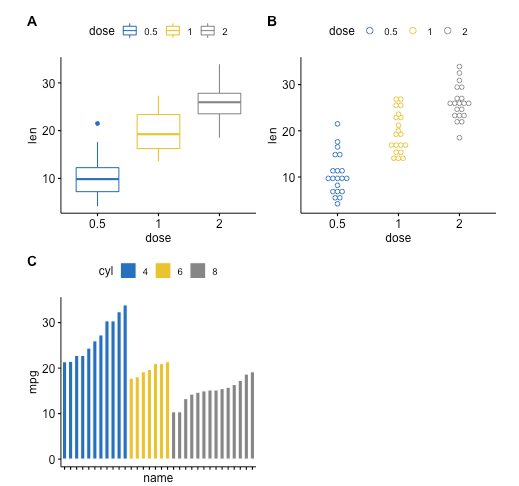

### plot upset-plot: share info

In [428]:
df_upset = df_wide_score.set_index('mpmat_index').applymap(lambda x: True if x>=0.001 else False).T
df_upset

mpmat_index,chr1_631391_631393,chr1_631778_631791,chr1_633067_633147,chr1_633244_633286,chr1_633376_633442,chr1_633641_633713,chr1_114004151_114004191,chr1_121618159_121618201,chr1_121750792_121750807,chr1_151197806_151197837,...,chr19_30664939_30664962,chr19_38962288_38962302,chr20_34129835_34129866,chr22_22357471_22357480,chr22_36511168_36511185,chrX_41024523_41024536,chrX_72126743_72126762,chrX_103211203_103211249,chrX_132292961_132292983,chrX_133005219_133005236
ATP8_DddA11_1,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
ATP8_DddA6_1,True,True,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
ATP8_DddAwt_1,True,False,False,False,True,True,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
JAK2_DddA11_1,False,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
SIRT6_DddA11_1,False,False,False,False,False,True,False,True,True,False,...,True,True,True,True,True,True,True,True,True,True


In [429]:
%%R -i df_upset
df_upset = as.data.frame(df_upset)
df_upset <- df_upset %>%
    as_tibble(rownames="Treatment") %>%
    gather(OTs, Member, -Treatment) %>%
    filter(Member) %>%
    select(- Member)

df_upset %>% head()

# A tibble: 6 × 2
  Treatment     OTs               
  <chr>         <chr>             
1 ATP8_DddA11_1 chr1_631391_631393
2 ATP8_DddA6_1  chr1_631391_631393
3 ATP8_DddAwt_1 chr1_631391_631393
4 ATP8_DddA11_1 chr1_631778_631791
5 ATP8_DddA6_1  chr1_631778_631791
6 ATP8_DddA11_1 chr1_633067_633147


In [430]:
%%R
# 后续考虑用 UpSetR 画，这样总体也有体现
# 或者再画一个躺倒的 barplot 然后拼起来
# https://cran.r-project.org/web/packages/UpSetR/vignettes/basic.usage.html
# movies <- read.csv(system.file("extdata", "movies.csv", package="UpSetR"),
#                    header=T, sep=";")
# head(movies)
# head(t(df_upset))

NULL


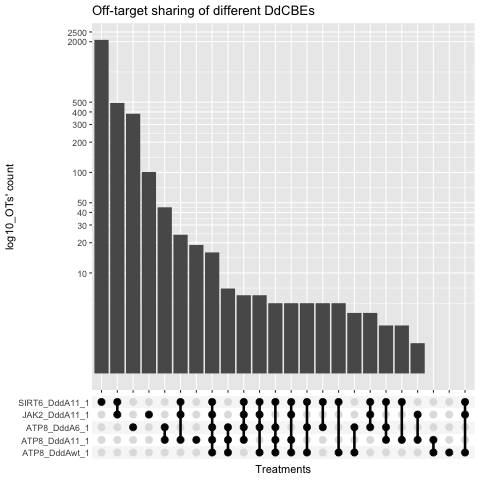

In [431]:
%%R
g = df_upset %>%
    group_by(OTs) %>%
    summarize(Treatments=list(Treatment)) %>%
    ggplot(aes(x=Treatments)) +
        geom_bar() +
        scale_x_upset() +
        scale_y_log10(
            breaks=c(10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 2000, 2500)
        ) +
        ylab('log10_OTs\' count') +
        ggtitle('Off-target sharing of different DdCBEs')
        theme_bw()
ggsave('2022-10-30_Detect-seq_upset-plot_all.pdf', plot=g, width=8, height=9)
g

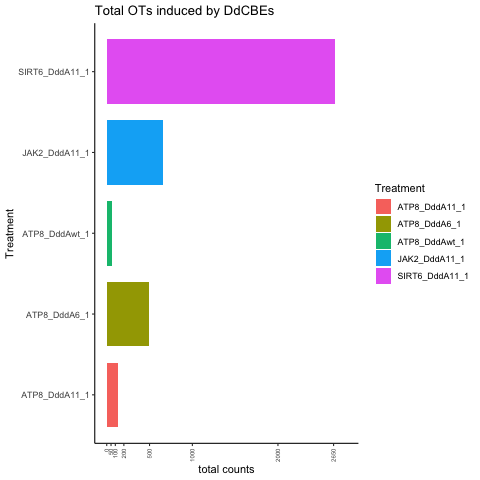

In [436]:
%%R
g = ggplot(df_upset) +
    geom_bar(
        aes(x=Treatment, fill=Treatment, group=Treatment),
        stat='count',
        width=0.8
    ) +
    scale_y_continuous(
        limits=c(0, 2800),
        breaks=c(0, 50, 100, 200, 500, 1000, 2000, 2650)
    ) +
    ylab("total counts") +
    ggtitle("Total OTs induced by DdCBEs") +
    coord_flip() +
    theme_classic() +
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1, size=6))

ggsave('2022-10-30_Detect-seq_bar-plot_all.pdf', plot=g, width=8, height=4)
g

In [437]:
%%R
df_upset %>%
    group_by(OTs) %>%
    filter(grepl("ATP8", Treatment))

# A tibble: 682 × 2
# Groups:   OTs [551]
   Treatment     OTs               
   <chr>         <chr>             
 1 ATP8_DddA11_1 chr1_631391_631393
 2 ATP8_DddA6_1  chr1_631391_631393
 3 ATP8_DddAwt_1 chr1_631391_631393
 4 ATP8_DddA11_1 chr1_631778_631791
 5 ATP8_DddA6_1  chr1_631778_631791
 6 ATP8_DddA11_1 chr1_633067_633147
 7 ATP8_DddA6_1  chr1_633067_633147
 8 ATP8_DddA11_1 chr1_633244_633286
 9 ATP8_DddA6_1  chr1_633244_633286
10 ATP8_DddA11_1 chr1_633376_633442
# … with 672 more rows
# ℹ Use `print(n = ...)` to see more rows


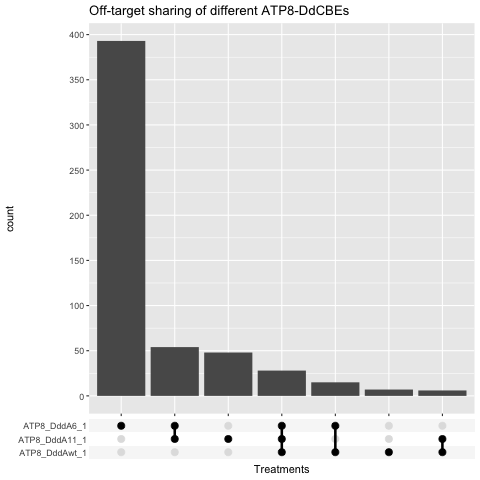

In [439]:
%%R
g = df_upset %>%
    group_by(OTs) %>%
    filter(grepl("ATP8", Treatment)) %>%
    summarize(Treatments=list(Treatment)) %>%
    ggplot(aes(x=Treatments)) +
        geom_bar() +
        scale_x_upset() +
        scale_y_continuous(
            breaks=seq(0, 400, 50)
        ) +
        ggtitle('Off-target sharing of different ATP8-DdCBEs')
        theme_bw()
ggsave('2022-10-30_Detect-seq_upset-plot_all_ATP8.pdf', plot=g, width=8, height=9)
g

### plot ATP8_DddAwt_1 vs ATP8_DddA6_1

In [463]:
# load data in R env
df2r = df_wide_score[['mpmat_index', 'ATP8_DddAwt_1', 'ATP8_DddA6_1']].copy()
df2r['color'] = df2r.apply(map_color, axis=1)
df2r = df2r.query('color.notnull()')
df2r

,mpmat_index,ATP8_DddAwt_1,ATP8_DddA6_1,color
0,chr1_631391_631393,0.004086,0.371259,b
1,chr1_631778_631791,0.000000,0.312616,b
2,chr1_633067_633147,0.000000,0.105701,b
3,chr1_633244_633286,0.000000,0.064643,b
4,chr1_633376_633442,0.011412,0.166584,ab
...,...,...,...,...
2861,chr9_40992885_40992908,0.000000,0.086952,b
2862,chr11_101860949_101860966,0.000000,0.039002,b
2863,chr12_108063343_108063381,0.000000,0.040479,b
2864,chr17_1056219_1056232,0.000000,0.067197,b


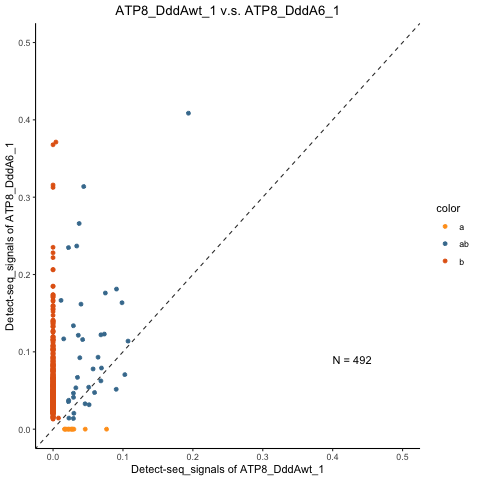

In [464]:
%%R -i df2r
df = as.data.frame(df2r)
# head(df, 10)

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddAwt_1,
            y=ATP8_DddA6_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_continuous(
        name="Detect-seq_signals of ATP8_DddAwt_1",
        limits=c(0, 0.5),
    ) +
    scale_y_continuous(
        name="Detect-seq_signals of ATP8_DddA6_1",
        limits=c(0, 0.5),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("ATP8_DddAwt_1 v.s. ATP8_DddA6_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_ATP8_DddAwt_1v.s.ATP8_DddA6_1.pdf', plot=g, width=4.6, height=4)
g

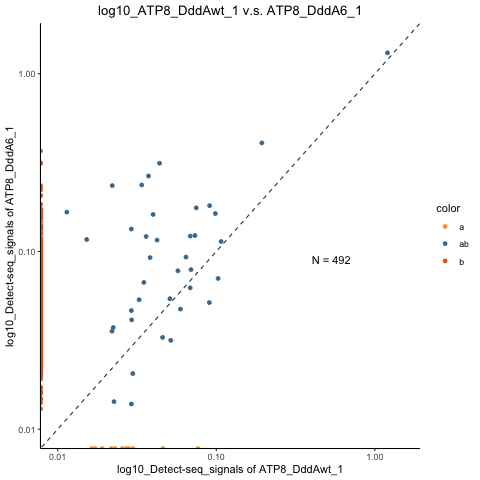

In [465]:
%%R

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddAwt_1,
            y=ATP8_DddA6_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_log10(
        name="log10_Detect-seq_signals of ATP8_DddAwt_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.0001, 0.001, 0.01, 0.1, 1),
    ) +
    scale_y_log10(
        name="log10_Detect-seq_signals of ATP8_DddA6_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.01, 0.1, 1, 10, 100, 1000),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("log10_ATP8_DddAwt_1 v.s. ATP8_DddA6_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_log10_ATP8_DddAwt_1v.s.ATP8_DddA6_1.pdf', plot=g, width=4.6, height=4)
g

### plot ATP8_DddAwt_1 vs ATP8_DddA11_1

In [466]:
# load data in R env
df2r = df_wide_score[['mpmat_index', 'ATP8_DddAwt_1', 'ATP8_DddA11_1']].copy()
df2r['color'] = df2r.apply(map_color, axis=1)
df2r = df2r.query('color.notnull()')
df2r

,mpmat_index,ATP8_DddAwt_1,ATP8_DddA11_1,color
0,chr1_631391_631393,0.004086,0.243265,b
1,chr1_631778_631791,0.000000,0.443596,b
2,chr1_633067_633147,0.000000,0.181528,b
3,chr1_633244_633286,0.000000,0.031852,b
4,chr1_633376_633442,0.011412,0.063662,ab
...,...,...,...,...
2855,chr17_8410441_8410462,0.025608,0.018873,ab
2857,chr17_76681403_76681420,0.000000,0.117470,b
2858,chr21_32940622_32940639,0.000000,0.035123,b
2860,chr7_15721070_15721094,0.045853,0.000000,a


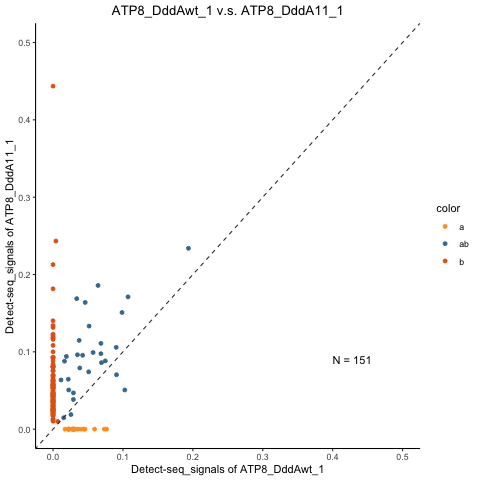

In [467]:
%%R -i df2r
df = as.data.frame(df2r)
# head(df, 10)

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddAwt_1,
            y=ATP8_DddA11_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_continuous(
        name="Detect-seq_signals of ATP8_DddAwt_1",
        limits=c(0, 0.5),
    ) +
    scale_y_continuous(
        name="Detect-seq_signals of ATP8_DddA11_1",
        limits=c(0, 0.5),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("ATP8_DddAwt_1 v.s. ATP8_DddA11_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_ATP8_DddAwt_1v.s.ATP8_DddA11_1.pdf', plot=g, width=4.6, height=4)
g

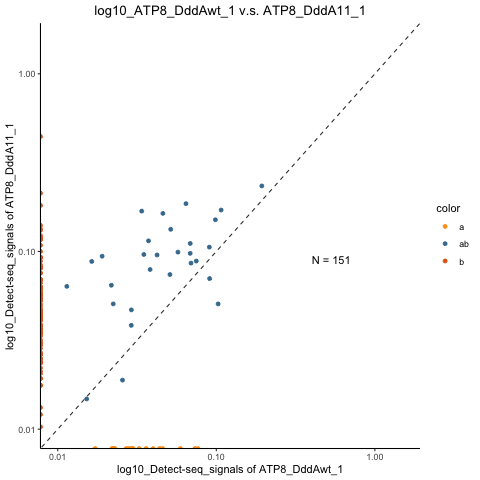

In [468]:
%%R

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddAwt_1,
            y=ATP8_DddA11_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_log10(
        name="log10_Detect-seq_signals of ATP8_DddAwt_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.0001, 0.001, 0.01, 0.1, 1),
    ) +
    scale_y_log10(
        name="log10_Detect-seq_signals of ATP8_DddA11_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.01, 0.1, 1, 10, 100, 1000),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("log10_ATP8_DddAwt_1 v.s. ATP8_DddA11_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_log10_ATP8_DddAwt_1v.s.ATP8_DddA11_1.pdf', plot=g, width=4.6, height=4)
g

### plot ATP8_DddA6_1 vs ATP8_DddA11_1

In [470]:
# load data in R env
df2r = df_wide_score[['mpmat_index', 'ATP8_DddA6_1', 'ATP8_DddA11_1']].copy()
df2r['color'] = df2r.apply(map_color, axis=1)
df2r = df2r.query('color.notnull()')
df2r

,mpmat_index,ATP8_DddA6_1,ATP8_DddA11_1,color
0,chr1_631391_631393,0.371259,0.243265,ab
1,chr1_631778_631791,0.312616,0.443596,ab
2,chr1_633067_633147,0.105701,0.181528,ab
3,chr1_633244_633286,0.064643,0.031852,ab
4,chr1_633376_633442,0.166584,0.063662,ab
...,...,...,...,...
2861,chr9_40992885_40992908,0.086952,0.000000,a
2862,chr11_101860949_101860966,0.039002,0.000000,a
2863,chr12_108063343_108063381,0.040479,0.000000,a
2864,chr17_1056219_1056232,0.067197,0.000000,a


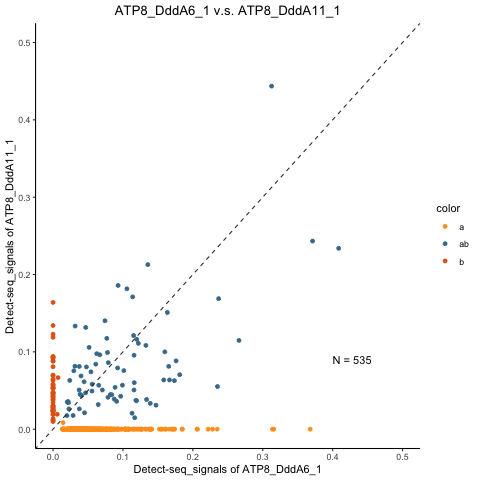

In [471]:
%%R -i df2r
df = as.data.frame(df2r)
# head(df, 10)

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddA6_1,
            y=ATP8_DddA11_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_continuous(
        name="Detect-seq_signals of ATP8_DddA6_1",
        limits=c(0, 0.5),
    ) +
    scale_y_continuous(
        name="Detect-seq_signals of ATP8_DddA11_1",
        limits=c(0, 0.5),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("ATP8_DddA6_1 v.s. ATP8_DddA11_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_ATP8_DddA6_1v.s.ATP8_DddA11_1.pdf', plot=g, width=4.6, height=4)
g

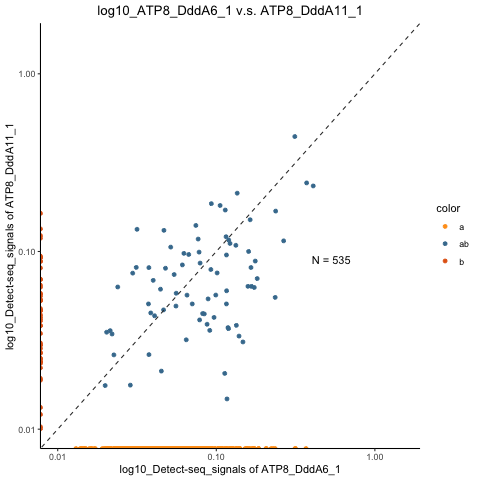

In [472]:
%%R

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddA6_1,
            y=ATP8_DddA11_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_log10(
        name="log10_Detect-seq_signals of ATP8_DddA6_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.0001, 0.001, 0.01, 0.1, 1),
    ) +
    scale_y_log10(
        name="log10_Detect-seq_signals of ATP8_DddA11_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.01, 0.1, 1, 10, 100, 1000),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("log10_ATP8_DddA6_1 v.s. ATP8_DddA11_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_log10_ATP8_DddA6_1v.s.ATP8_DddA11_1.pdf', plot=g, width=4.6, height=4)
g

### plot ATP8_DddA11_1 vs JAK2_DddA11_1

In [473]:
# load data in R env
df2r = df_wide_score[['mpmat_index', 'ATP8_DddA11_1', 'JAK2_DddA11_1']].copy()
df2r['color'] = df2r.apply(map_color, axis=1)
df2r = df2r.query('color.notnull()')
df2r

,mpmat_index,ATP8_DddA11_1,JAK2_DddA11_1,color
0,chr1_631391_631393,0.243265,0.000000,a
1,chr1_631778_631791,0.443596,0.000000,a
2,chr1_633067_633147,0.181528,0.000000,a
3,chr1_633244_633286,0.031852,0.000000,a
4,chr1_633376_633442,0.063662,0.000000,a
...,...,...,...,...
3148,chrX_23318289_23318311,0.000000,0.130721,b
3149,chrX_53482280_53482301,0.000000,0.045222,b
3150,chrX_104136591_104136605,0.000000,0.022952,b
3151,chrX_115147404_115147425,0.000000,0.050274,b


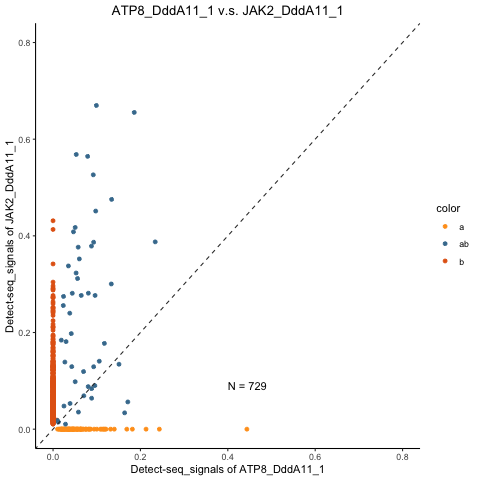

In [474]:
%%R -i df2r
df = as.data.frame(df2r)
# head(df, 10)

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddA11_1,
            y=JAK2_DddA11_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_continuous(
        name="Detect-seq_signals of ATP8_DddA11_1",
        limits=c(0, 0.8),
    ) +
    scale_y_continuous(
        name="Detect-seq_signals of JAK2_DddA11_1",
        limits=c(0, 0.8),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("ATP8_DddA11_1 v.s. JAK2_DddA11_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_ATP8_DddA11_1v.s.JAK2_DddA11_1.pdf', plot=g, width=4.6, height=4)
g

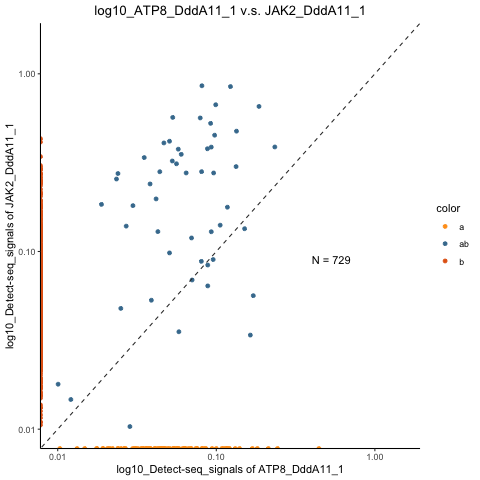

In [475]:
%%R

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddA11_1,
            y=JAK2_DddA11_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_log10(
        name="log10_Detect-seq_signals of ATP8_DddA11_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.0001, 0.001, 0.01, 0.1, 1),
    ) +
    scale_y_log10(
        name="log10_Detect-seq_signals of JAK2_DddA11_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.01, 0.1, 1, 10, 100, 1000),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("log10_ATP8_DddA11_1 v.s. JAK2_DddA11_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_log10_ATP8_DddA11_1v.s.JAK2_DddA11_1.pdf', plot=g, width=4.6, height=4)
g

### plot ATP8_DddA11_1 vs SIRT6_DddA11_1

In [476]:
# load data in R env
df2r = df_wide_score[['mpmat_index', 'ATP8_DddA11_1', 'SIRT6_DddA11_1']].copy()
df2r['color'] = df2r.apply(map_color, axis=1)
df2r = df2r.query('color.notnull()')
df2r

,mpmat_index,ATP8_DddA11_1,SIRT6_DddA11_1,color
0,chr1_631391_631393,0.243265,0.000000,a
1,chr1_631778_631791,0.443596,0.000000,a
2,chr1_633067_633147,0.181528,0.000000,a
3,chr1_633244_633286,0.031852,0.000000,a
4,chr1_633376_633442,0.063662,0.000000,a
...,...,...,...,...
3228,chrX_41024523_41024536,0.000000,0.108216,b
3229,chrX_72126743_72126762,0.000000,0.036446,b
3230,chrX_103211203_103211249,0.000000,0.035829,b
3231,chrX_132292961_132292983,0.000000,0.013551,b


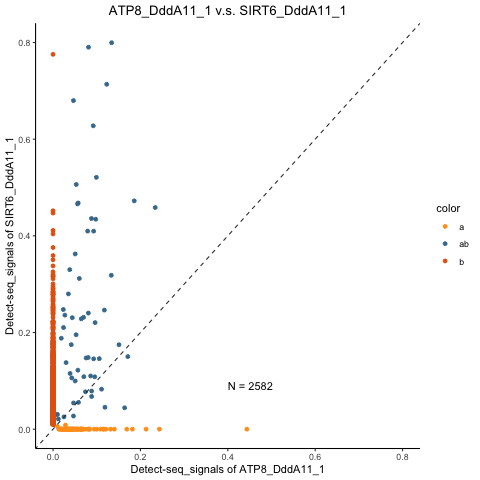

In [477]:
%%R -i df2r
df = as.data.frame(df2r)
# head(df, 10)

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddA11_1,
            y=SIRT6_DddA11_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_continuous(
        name="Detect-seq_signals of ATP8_DddA11_1",
        limits=c(0, 0.8),
    ) +
    scale_y_continuous(
        name="Detect-seq_signals of SIRT6_DddA11_1",
        limits=c(0, 0.8),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("ATP8_DddA11_1 v.s. SIRT6_DddA11_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_ATP8_DddA11_1v.s.SIRT6_DddA11_1.pdf', plot=g, width=4.6, height=4)
g

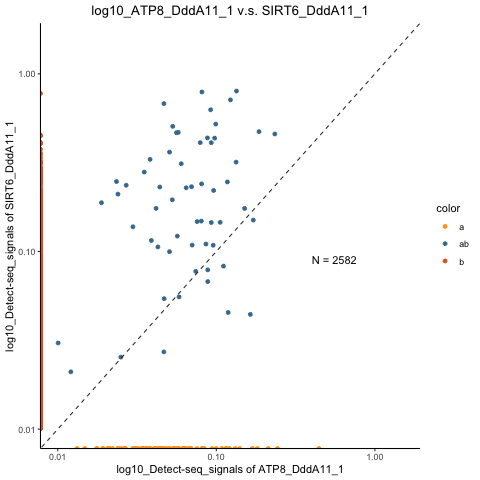

In [478]:
%%R

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=ATP8_DddA11_1,
            y=SIRT6_DddA11_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_log10(
        name="log10_Detect-seq_signals of ATP8_DddA11_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.0001, 0.001, 0.01, 0.1, 1),
    ) +
    scale_y_log10(
        name="log10_Detect-seq_signals of SIRT6_DddA11_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.01, 0.1, 1, 10, 100, 1000),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("log10_ATP8_DddA11_1 v.s. SIRT6_DddA11_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_log10_ATP8_DddA11_1v.s.SIRT6_DddA11_1.pdf', plot=g, width=4.6, height=4)
g

### plot JAK2_DddA11_1 vs SIRT6_DddA11_1

In [479]:
# load data in R env
df2r = df_wide_score[['mpmat_index', 'JAK2_DddA11_1', 'SIRT6_DddA11_1']].copy()
df2r['color'] = df2r.apply(map_color, axis=1)
df2r = df2r.query('color.notnull()')
df2r

,mpmat_index,JAK2_DddA11_1,SIRT6_DddA11_1,color
7,chr1_121618159_121618201,0.018814,0.030136,ab
8,chr1_121750792_121750807,0.090096,0.108407,ab
22,chr3_90515287_90515305,0.000000,0.054253,b
42,chr6_72412316_72412386,0.035352,0.000000,a
45,chr7_60232407_60232481,0.014691,0.021030,ab
...,...,...,...,...
3228,chrX_41024523_41024536,0.000000,0.108216,b
3229,chrX_72126743_72126762,0.000000,0.036446,b
3230,chrX_103211203_103211249,0.000000,0.035829,b
3231,chrX_132292961_132292983,0.000000,0.013551,b


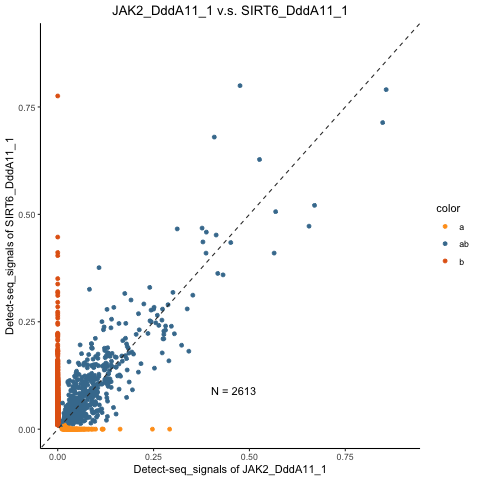

In [480]:
%%R -i df2r
df = as.data.frame(df2r)
# head(df, 10)

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=JAK2_DddA11_1,
            y=SIRT6_DddA11_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_continuous(
        name="Detect-seq_signals of JAK2_DddA11_1",
        limits=c(0, 0.9),
    ) +
    scale_y_continuous(
        name="Detect-seq_signals of SIRT6_DddA11_1",
        limits=c(0, 0.9),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("JAK2_DddA11_1 v.s. SIRT6_DddA11_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_JAK2_DddA11_1v.s.SIRT6_DddA11_1.pdf', plot=g, width=4.6, height=4)
g

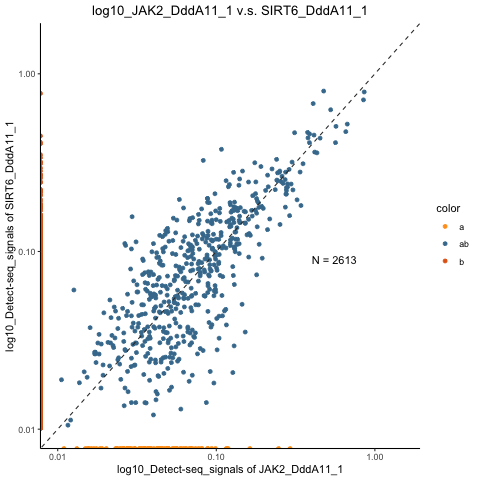

In [481]:
%%R

g = ggplot(data=df) +
    geom_point(
        mapping=aes(
            x=JAK2_DddA11_1,
            y=SIRT6_DddA11_1,
            # alpha=0.99,
            # size=1,
            color=color,
            fill=color,
            # shape=color,
            # group=color,
        )
    ) +
    scale_color_manual(values=c("#ff9f1c", "#447B9D", "#e36414")) +
    scale_x_log10(
        name="log10_Detect-seq_signals of JAK2_DddA11_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.0001, 0.001, 0.01, 0.1, 1),
    ) +
    scale_y_log10(
        name="log10_Detect-seq_signals of SIRT6_DddA11_1",
        limits=c(0.01, 1.5),
        # breaks=c(0.01, 0.1, 1, 10, 100, 1000),
    ) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="#333333") +
    annotate("text", x=0.4, y=0.09, hjust=0, parse=F, colour="black", label=sprintf("N = %i", dim(df)[1])) +
    ggtitle("log10_JAK2_DddA11_1 v.s. SIRT6_DddA11_1") +
    theme_classic() +
    theme(plot.title=element_text(hjust=0.5))

ggsave('2022-10-30_Detect-seq_scatter-plot_log10_JAK2_DddA11_1v.s.SIRT6_DddA11_1.pdf', plot=g, width=4.6, height=4)
g

## 2022-10-21 co-localization between all CTCF peaks and Detect-seq signals from different DdCBE treatments

# IGV 截图脚本

In [ ]:
df_igv = df_pois[[
    'chr_name', 'region_start', 'region_end', 'bed_name', 'log2_FC_mut'
]]
df_igv.head()

In [ ]:
# 理论上这里得到的是所有 samples 的 candidate list
# 经过先 merge mpmat 的处理，再 call 点，应该不存在能 overlap 到一起的 region，只能是样本间 share
# 相同位置或者 not share，不存在 overlap 又不相同的情况了

In [ ]:
df_igv.head()

In [ ]:
# 对call 到的所有点进行随机采样
np.random.seed = 2022
df_igv = df_igv.sample(n=300)
df_igv

In [ ]:
# 整理df格式为bed文件格式
print(df_igv)
#        0          1          2
# 0   chr5   69093805   69093830
# 1   chr8   37153384   37153424
# 2  chr15   57559994   57560017
# 3  chr15   68651256   68651277
# 4  chr10  119445511  119445546
# 5   chr8   20184990   20185028
# 6  chr19   45187694   45187712
# 7  chr15   81265992   81266016
# 8   chr2  201232409  201232430
# 9   chr9   98034893   98034930

In [ ]:
# 填写相关信息

path_out = '/Volumes/zhaohn_HD/3.project/2022_DdCBE-3D-Genome_topic/2022-09-30_Detect-seq_batch-1/igv'
date = 20221027
format_ = "png"
height = 1500

# 格式化脚本
text = f"maxPanelHeight {height}\nsnapshotDirectory {path_out}/off-targets_{date}\n"
print(text)

In [ ]:
df_snapshot = df_igv.iloc[:, 0:5]

for index, row_info in df_snapshot.iterrows():
    chrom, start, stop, bed_name, score = row_info

    path_out_png = f'{score}_{bed_name}.snapshot.{format_}'
    middle = int((start + stop) / 2)

    text += f"goto {chrom}:{middle - 100}-{middle + 100}\nsnapshot {path_out_png}\n"
print(text[:1000])

In [ ]:
with open(f'{path_out}/off-targets_{date}_snapshot.igv_shot_script', 'wt') as f:
    f.write(text)

In [ ]:
# DetectSeq_JAK2
# DetectSeq_SIRT6
# IND share?

# off-target analysis

## off-target list

### circos plot

#### learn circos plot
- [tutorial1](https://colab.research.google.com/drive/1xmAnv7AHWUTA2HWfjqV1lFWkFMSLJHG0?usp=sharing)
- [tutorial2](https://colab.research.google.com/drive/1RYSo4aXpDIZlSQ9EhO2kPCeF8FOwyvXv?usp=sharing)
- [tutorial3](https://colab.research.google.com/drive/1EPxCQCgOouVxtXcGyxu2ZqQvfucVnOJ-?usp=sharing)
- [tutorial4(Drawing pylogenetic tree)](https://colab.research.google.com/drive/140m2jpQpgSZwSlP-3u3Oj8IcJUbP2NGD?usp=sharing)

In [ ]:
# pip install python-circos

In [ ]:
# !mkdir -p../ temp_file
# % cd../ temp_file
# !mkdir -p pycircos
# % cd pycircos
# !mkdir -p sample_data
# % cd sample_data

In [ ]:
# #The following example data was downloaded from https://venyao.xyz/shinyCircos/.
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_barplot.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_chromosome_cytoband.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_chromosome_general.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_links.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_point.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_rect_gradual.csv

In [ ]:
# % cd / Volumes / zhaohn_HD / 3.project / 2022_DdCBE-3D-Genome_topic / 2022-09-30_Detect-seq_batch-1 / snakepipes_detect-seq

#### circos plot

##### 准备 data

In [ ]:
# 基因组 fai 文件（染色体长度信息），区分 hg19 和 hg38
path_genome_length = '/Users/zhaohuanan/Bio/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa.fai'
df_genome_length = pd.read_csv(
    path_genome_length,
    header=None,
    sep='\t',
    usecols=[0, 1],
    names=['chrom', 'end'],
)
df_genome_length.insert(loc=1, column='start', value=1)

df_genome_length = df_genome_length\
    .query("chrom != 'chrY'")\
    .query("chrom != 'chrM'")

print(df_genome_length.head(2))

In [ ]:
# cytoband 信息，可以在 ucsc 下载，区分 hg19 和 hg38
df_genome_cytoband = pd.read_csv(
    "http://hgdownload.cse.ucsc.edu/goldenpath/hg38/database/cytoBand.txt.gz",
    header=None,
    sep='\t',
    usecols=range(5),
    names=['chrom', 'start', 'end', 'value1', 'value2'])
# 对 chromosome 进行过滤，保留标准染色体
df_genome_cytoband = df_genome_cytoband\
    .query("not chrom.str.endswith('fix')")\
    .query("not chrom.str.endswith('alt')")\
    .query("not chrom.str.endswith('random')")\
    .query("not chrom.str.startswith('chrUn')")\
    .query("chrom != 'chrY'")\
    .query("chrom != 'chrM'")
print(sorted(df_genome_cytoband.chrom.unique()))
print()
print(df_genome_cytoband.head(2))

In [ ]:
df_circos_point = df[[
    '<sample>', 'chr_name', 'region_start', 'region_end', 'log2_FC_mut'
]].copy()
df_circos_point.columns = ['sample', 'chrom', 'start', 'end', 'score']
df_circos_point.reset_index(inplace=True, drop=True)
df_circos_point

##### 设置比例尺

In [ ]:
scale = 1.1

In [ ]:
arc_range_i = df_circos_point['sample'].unique().__len__() + 1
arc_raixs_range = ((arc_range_i * 100.0) * scale,
                   (arc_range_i * 100.0 + 20) * scale)
arc_raixs_range

##### 设置染色体信息

In [ ]:
# set chromeosomes
circle = Gcircle()

for idx, row in df_genome_length.iterrows():
    chrom, start, end = row
    length = end - start + 1

    arc = Garc(
        arc_id=chrom,  # 染色体名称
        size=length,  # 染色体长度
        interspace=1,  # 间隔距离
        raxis_range=arc_raixs_range,  # 内外半径长度
        labelposition=60,  # 越往里越小，越往外越大
        label_visible=True,  # 是否展示 label，也就是染色体名称
    )
    circle.add_garc(arc)  # 添加一个染色体信息

circle.set_garcs()  # 整合设置所有添加过的染色体信息

##### 整理 cytoband 信息到arcdata\_dict

In [ ]:
# 定义不同 cytoband 的颜色
color_dict = {
    "gneg": "#FFFFFF00",
    "gpos25": "#EEEEEE",
    "gpos50": "#BBBBBB",
    "gpos75": "#777777",
    "gpos100": "#000000",
    "gvar": "#FFFFFF00",
    "stalk": "#C01E27",
    "acen": "#D82322"
}

# defaultdict的说明
# https://zhuanlan.zhihu.com/p/46476348
# 其实就是当引用的 key 不存在时返回默认值,这里是默认返回一个 dict 而不抛出 KeyError
arcdata_dict = collections.defaultdict(dict)  # 传入 dict 函数，调用时返回空 dict
# or
# arcdata_dict = collections.defaultdict(lambda: {})
# arcdata_dict

for idx, row in df_genome_cytoband.iterrows():
    chrom, start, end, value1, value2 = row
    width = end - start + 1
    # 在进行arcdata_dict对键chrom 取值取不到的时候
    # 默认创建空 dict 而不是 raise KeyError
    if chrom not in arcdata_dict:
        arcdata_dict[chrom]['positions'] = []
        arcdata_dict[chrom]['widths'] = []
        arcdata_dict[chrom]['colors'] = []
    else:
        arcdata_dict[chrom]['positions'].append(start)
        arcdata_dict[chrom]['widths'].append(width)
        arcdata_dict[chrom]['colors'].append(color_dict[value2])

print(arcdata_dict.__str__()[:1000])

##### 将 cytoband 信息加到 circle 对象中去

In [ ]:
for chrom in arcdata_dict:
    circle.barplot(chrom,
                   data=[1] * len(arcdata_dict[chrom]['positions']),
                   positions=arcdata_dict[chrom]['positions'],
                   width=arcdata_dict[chrom]['widths'],
                   raxis_range=arc_raixs_range,
                   facecolor=arcdata_dict[chrom]['colors'])

##### 查看绘制的circos plot骨架

In [ ]:
# circle.figure?
circle.figure

##### 添加每个样本中的 off-target sites 信息

In [ ]:
# TODO
# sample lable
# background color
# point color
# edge color of point

# scatter plot
counter_circle = 0
# color

for sample, sample_df in df_circos_point.groupby('sample'):
    print(sample, sample_df.shape[0])
    counter_circle += 1

    values_all = []
    arcdata_dict = collections.defaultdict(dict)

    for idx, row in sample_df.iterrows():
        _, chrom, start, end, score = row
        middle = (start + end) / 2
        values_all.append(score)

        if chrom not in arcdata_dict:
            arcdata_dict[chrom]["positions"] = []
            arcdata_dict[chrom]["values"] = []
        else:
            arcdata_dict[chrom]["positions"].append(middle)
            arcdata_dict[chrom]["values"].append(score)

    vmin, vmax = min(values_all), max(values_all)

    arc_raixs_range_sample = ((counter_circle * 100.0) * scale,
                              (counter_circle * 100.0 + 80) * scale)

    for chrom in arcdata_dict:
        circle.scatterplot(
            chrom,
            data=arcdata_dict[chrom]["values"],
            positions=arcdata_dict[chrom]["positions"],
            rlim=[vmin - 0.05 * abs(vmin), vmax + 0.05 * abs(vmax)],
            markershape='o',
            markersize=1,
            raxis_range=arc_raixs_range_sample,
            facecolor="#468FBE",
            edgecolor="#000000",
            linewidth=0.03,
            spine=True)

circle.figure

In [ ]:
circle.figure?


### upset plot

## signal strength

### scatter plot

## alignment
### art plot

## editing window
### indel comparation

## ctcf analysis
### shared off-target motif
### DddAwt,6,11 co-localization with ctcf